# Intersection Volume

In [1]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

### Volume for an Edge-Vertex contact.
We compute contact volumes per-edge using the edges earliest contact. For each edge, the volume is given by
$$
\newcommand{\bU}{\mathbf{U}}
\newcommand{\be}{\mathbf{e}}
V_k(\be) = (1 - \tau_I)\sqrt{\epsilon^2 |\be(\tau_I)|^2 + \bU_{ij} \cdot \be(\tau_I)^{\bot}}
$$

where 
- $|e(\tau_I)|$ is the length of the edge at the first time of collision ($\tau_I$), 
- $\epsilon$ is some small value
- $\bU_{ij}$ is the velocity of the contact point at the edge. 

Let $\bU_i,\bU_j,\bU_k$ be the velocities (i.e also distances since $dt=1$) of the three vertexes. We can compute $\bU_{ij}$, the velocity of the contact point along the edge as

$$ \bU_{ij} = \bU_{i} + \alpha_{\tau} (\bU_{j} - \bU_{i}) $$

where $\alpha_{\tau}$ is the distance along the edge where the first contact happens ( $0\leq \alpha \leq 1$).


In [2]:
import sympy as sympy
import numpy as np
from sympy import init_printing
init_printing()

In [3]:
i,j,k,l = np.arange(0,4)
v = sympy.symbols("Vi:l[0:2]", real=True) # vertices positions
v = [sympy.Matrix(v[2*i:2*i+2]) for i in range(0,4)]
u = sympy.symbols("Ui:l[0:2]", real=True) # vertices velocities
u = [sympy.Matrix(u[2*i:2*i+2]) for i in range(0,4)]

toi, alpha, epsilon = sympy.symbols("toi alpha epsilon", real=True)

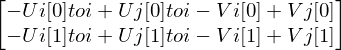

In [5]:
e_toi = (v[j] + toi * u[j]) - (v[i] + toi * u[i])
e_toi

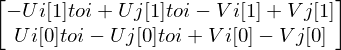

In [6]:
e_rot90_toi = sympy.Matrix([e_toi[1], -e_toi[0]])
e_rot90_toi

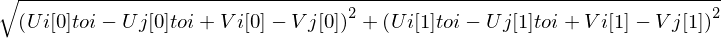

In [7]:
e_length_toi = e_rot90_toi.norm()
sympy.simplify(e_length_toi)

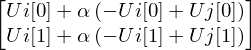

In [8]:
u_ij = u[i] + alpha * (u[j] - u[i])
u_ij

In [9]:
U_ij_dot_e_rot90_toi = (u_ij.T * e_rot90_toi)[0]
U_ij_dot_e_rot90_toi

In [10]:
volume = (1.0 - toi) * sympy.sqrt(epsilon **2 * e_length_toi **2 + U_ij_dot_e_rot90_toi **2)


In [11]:
volume = sympy.Piecewise((-volume, volume > 0), (volume, True))

In [12]:
from sympy import *
from sympy.matrices import *
from sympy.printing.ccode import C99CodePrinter
from sympy.printing.precedence import precedence

assert_ = sympy.Function('assert')


custom_functions = {'assert':'assert'}
class MyPrinter(C99CodePrinter):
    pass

def C99_print(expr, expr_names):
    expr = [sympy.simplify(e) for e in expr]
    CSE_results = cse(expr, numbered_symbols("helper_"), optimizations='basic')
    lines = []
    for helper in CSE_results[0]:
        if isinstance(helper[1], MatrixSymbol):
            lines.append('const auto ' + str(helper[0]) + '[' + str(helper[1].rows * helper[1].cols) + '];\n')
            lines.append(ccode(helper[1], helper[0]))
        else:
            lines.append('const auto %s' % ccode(helper[1], helper[0]))

    lines.append('')
    for i, result in enumerate(CSE_results[1]):
        name = expr_names[i]
        if expr_names[i] == None:
            lines.append("%s;" % ccode(result, name))
        else:
            
            lines.append(ccode(result, name))
    return '\n'.join(lines)

my_printer = MyPrinter({'user_functions':custom_functions})
def ccode(expr, assign_to=None):
    return my_printer.doprint(expr, assign_to)



In [13]:
results = [assert_(e_length_toi > 0), assert_(U_ij_dot_e_rot90_toi > 0), volume]
results_names = [None, None, 'volume']
print(C99_print(results, results_names))

const auto helper_0 = Ui[0]*toi - Uj[0]*toi + Vi[0] - Vj[0];
const auto helper_1 = Ui[1]*toi - Uj[1]*toi + Vi[1] - Vj[1];
const auto helper_2 = pow(helper_0, 2) + pow(helper_1, 2);
const auto helper_3 = helper_0*(Ui[1] - alpha*(Ui[1] - Uj[1]));
const auto helper_4 = helper_1*(Ui[0] - alpha*(Ui[0] - Uj[0]));
const auto helper_5 = (toi - 1.0)*sqrt(pow(epsilon, 2)*helper_2 + pow(-helper_3 + helper_4, 2));
const auto helper_6 = -helper_5;

assert(sqrt(helper_2) > 0);
assert(helper_3 - helper_4 > 0);
if (helper_6 > 0) {
   volume = helper_5;
}
else {
   volume = helper_6;
}
